In [35]:
try:
    passes += 1
    !git pull
except:
    passes = 1
    !git clone https://github.com/arminwitte/FoolsUNet.git
    %cd FoolsUNet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Already up to date.


In [36]:
import tensorflow as tf

print(tf.__version__)

2.15.0


In [37]:
import tensorflow_datasets as tfds

In [38]:
dataset, info = tfds.load(
    "tf_flowers:3.*.*", with_info=True, data_dir="./data/",
                         split=['train[:75%]','train[75%:]']
                         )

In [54]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='./data/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [39]:
dataset

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]

In [40]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image

In [41]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (256, 256))
    input_label = datapoint["label"]

    input_image = normalize(input_image)

    return input_image, input_label

In [42]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [43]:
train_images = dataset[0].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset[1].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [44]:
from tensorflow.keras import layers
class Augment(layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [45]:
train_batches = (
    train_images.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

## Get pre-trained encoder and attach classification head

In [46]:
from foolsunet.model import foolsunet

In [47]:
base_model = foolsunet()#tf.keras.models.load_model("foolsunet_oxfordpet.keras")
base_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_downsample  │ (None, 128, 128,  │      1,728 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_2_downsample  │ (None, 64, 64,    │     74,240 │ block_1_downsamp… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_3_invres_dow… │ (None, 32, 32,    │    142,788 │ block_2_downsamp… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_4_invres_dow… │ (None, 16, 16,    │    284,384 │ block_3_invres_d… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_5_invres_dow… │ (None, 8, 8, 128) │    499,206 │ block_4_invres_d… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_6_invres_ups… │ (None, 16, 16,    │    802,464 │ block_5_invres_d… │
│ (Sequential)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ block_6_invres_u… │
│ (Concatenate)       │ 192)              │            │ block_4_invres_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_7_invres_ups… │ (None, 32, 32,    │    402,880 │ concatenate[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ block_7_invres_u… │
│ (Concatenate)       │ 128)              │            │ block_3_invres_d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_8_upsample    │ (None, 64, 64,    │    147,968 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ block_8_upsample… │
│ (Concatenate)       │ 256)              │            │ block_2_downsamp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_9_upsample    │ (None, 128, 128,  │    147,712 │ concatenate_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ block_9_upsample… │
│ (Concatenate)       │ 128)              │            │ block_1_downsamp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output              │ (None, 256, 256,  │      3,459 │ concatenate_3[0]… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,506,829 (9.56 MB)

 Trainable params: 2,485,169 (9.48 MB)

 Non-trainable params: 21,660 (84.61 KB)

### Define encoder

In [48]:
# Use the activations of these layers
layer_names = [
    'block_1_downsample',
    'block_2_downsample',
    'block_3_invres_downsample',
    'block_4_invres_downsample',
    'block_5_invres_downsample',
]
base_model_layers = [base_model.get_layer(name) for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False

### Define classifier

In [49]:
def foolsclassifier():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = inputs
#     x = base_model.input
#     x = down_stack(inputs)
    for layer in base_model_layers:
#         layer.trainable = False
        x = layer(x)
    x = tf.keras.layers.Flatten(name="block_6_flatten")(x)
    x = tf.keras.layers.Dense(128, activation='relu',name="block_7_dense")(x)
    x = tf.keras.layers.Dense(num_classes, name="outputs")(x)

    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [50]:
num_classes = 1000

In [51]:
model = foolsclassifier()
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.summary()


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1_downsample (Sequential) │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2_downsample (Sequential) │ (None, 64, 64, 128)    │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3_invres_downsample       │ (None, 32, 32, 64)     │       142,788 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4_invres_downsample       │ (None, 16, 16, 96)     │       284,384 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_5_invres_downsample       │ (None, 8, 8, 128)      │       499,206 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_6_flatten (Flatten)       │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_7_dense (Dense)           │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,180,050 (8.32 MB)

 Trainable params: 2,167,734 (8.27 MB)

 Non-trainable params: 12,316 (48.11 KB)

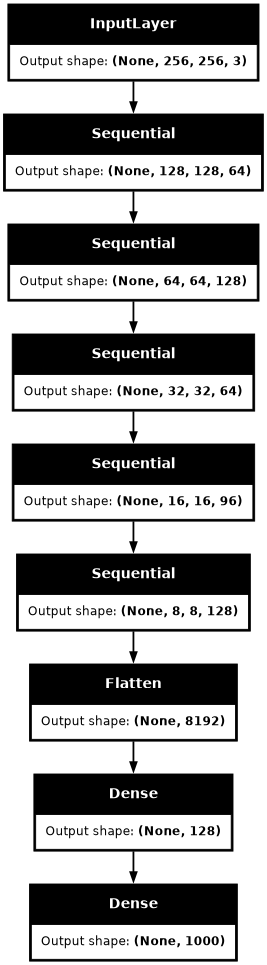

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = int(info.splits["train"].num_examples*0.25) // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_batches,
    # callbacks=[DisplayCallback()]
)

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save("foolsunet_imagenet_resized.keras")
model.save_weights("foolsunet_imagenet_resized.weights.h5")

In [ ]:
new_model = tf.keras.models.load_model("foolsunet_imagenet_resized.keras.keras")

# Show the model architecture
new_model.summary()